# Land-use classification using Semantic Segmentation
Johnathan Clementi & Gianluca Mangiapane   
Remote Sensing: MUSA 650, Spring 2022   

### Problem:
In image analysis, traditional classification methods return a single output label for each image. In the context of land-use classification from satelitte/aerial imagery, a traditional classification model would only return a single label for an image that has many land-use types within it. However, there are often many different types of land-use held within a single satelitte or aerial image. Therefore, an issue may arise when trying to understand the distribution of certain types of land use within a single image. If there are multiple land-use types and the the classifier will assign that image a single label, the remaining land-use data that doesn't fall under the single-classification is then hidden from the user, which could be useful or valubale information. Thus, we hope to solve this problem through utilizing semantic segmentation, or the classification of individual pixels (and therefore all the different classes) within an image. 

### Methods 

The primary method that we aim to use is that of Semantic Segmentation, a form of dense prediction where every pixel in an image is given a label of a corresponding class. Semantic Segmentation has become prevalent in both the medical field as a way of identifying harmful cells from healthy cells in brain and organ scans, and autonomous driving cars being able to idenfity free road spcae from other vehicles, pedestrians, and road signs. However, there has also been a growing application of Semantic Segmentation to the field of Remote Sensing, and identifying different classes of land use and objects from satellite imagery. 

Our segmentation method will consist of applying a U-net on our image dataset. A U-net initially follows a general CNN architecture of convolutional and pooling layers, but it starts with encoding the input image down to a simplied features map, and then decodes that map back up to the input image, through deconvolutional layers, and therefore becomes a fully convolutional network. A defining feature of the U-net is that at every up-sampling of the decoder layer (the upwards of the U), information is sent from its respective down-sampling of the encoder layer. The encoder layer has more defined information, and therefore helps the decoder layer have more accurate outputs. 

Considering Image Segmentation is a very complicated process in and of itself, if we run into difficulties with the image dataset's current form, one back up proposal is that we can split individual images into squares of equal size, and decrease the number of different classes in each sqaure. From there, we can perform a more mangeable multi-classification approach, such as a traditional CNN with convulutional and pooling layers instead of a U-NET. 

### Datasets to use 

We plan on using Earth Imagery collected by the DigitialGlobe satellite in 2018, and presented as a challenge to "Parse the Earth through Satellite Images" by Cornell University. The dataset was also provided on Kaggle. 

  -Challenge Information 
  https://arxiv.org/abs/1805.06561 

  -Kaggle Link
  https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset 



The training data contains 803 satellite imagery in RGB, size 2448 x 2448, with pixel resolution of 50cm. The dataset also contains 171 validation and 172 test images, with no masks. In the masks for the training set, each of the 7 classes has a corresponding RBG value as follows: Urban (0,255,255), Agriculture land (255,255,0), Rangeland (255,0,255), Forest land (0,255,0), Water (0,0,255), Barren land (255,255,255), and Unknown (0,0,0) i.e., clouds and others. 

Once we have our project model trained to an acceptable level of performance, an additional goal we have is to use our model on the Microsoft Chesapeake NAIP imagery to see if our model can segmentic land types in a real world application. 

https://mlhub.earth/data/microsoft_chesapeake 



### Background information Sources

https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47 

https://nanonets.com/blog/semantic-image-segmentation-2020/ 

https://keras.io/examples/vision/oxford_pets_image_segmentation/ 


In [1]:
!pip install tensorflow

In [14]:
## import packages
import os, cv2
import numpy as np 
import pandas as pd 
import math
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [15]:
# Import functions from Kaggle example code:

# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(10,10))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        image = mpimg.imread(image)
        plt.imshow(image)
    plt.show()

In [3]:
## Mount drive folder
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
## Create path to data

# Gianluca's Path:
# path = "/content/drive/MyDrive/FinalPrj/data"

# Johnathan's Path:
path = "/content/drive/MyDrive/Grad School/Penn_MUSA/Spring2022/650_RemoteSensing/FinalPrj/data"

In [6]:
## Classes and their respective pixel values
class_dict = pd.read_csv('{}/class_dict.csv'.format(path))
class_names = class_dict['name'].values.tolist()
class_rgb_vals = class_dict[['r', 'g', 'b']].values.tolist()

# Useful to shortlist specific classes in datasets with large number of classes
select_classes = class_names

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_vals)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_vals)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [7]:
# Load metadata file - contains relative paths for images and masks
metadata = pd.read_csv('{}/metadata.csv'.format(path))

# Preparing metadata for use
metadata = metadata[metadata['split']=='train'] # Filter out images that do not have masks (those images are part of the challenge set)
metadata = metadata[['image_id', 'sat_image_path', 'mask_path']] # Remove the image status column

# set paths to absolute paths rather than relative paths:
metadata['sat_image_path'] = metadata['sat_image_path'].apply(lambda img_pth: os.path.join(path, img_pth))
metadata['mask_path'] = metadata['mask_path'].apply(lambda img_pth: os.path.join(path, img_pth))

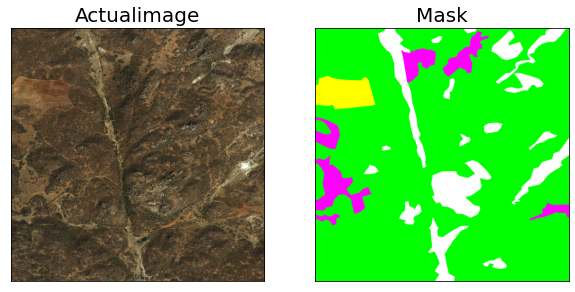

In [18]:
img = metadata['sat_image_path'][123]
mask = metadata['mask_path'][123]
visualize(Image = dat, Mask = mask)

In [8]:
# Shuffle DataFrame
metadata = metadata.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata.sample(frac=0.1, random_state=42)
train_df = metadata.drop(valid_df.index)
len(train_df), len(valid_df)

(723, 80)